<a href="https://colab.research.google.com/github/jjrodcast/Notebook-Algorithms/blob/master/Stitching_Images_HomeWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!wget www.ivan-sipiran.com/downloads/Imagenes.zip
!unzip Imagenes.zip
!rm Imagenes.zip

--2020-04-02 00:21:39--  http://www.ivan-sipiran.com/downloads/Imagenes.zip
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30498456 (29M) [application/zip]
Saving to: ‘Imagenes.zip’

Imagenes.zip        100%[===================>]  29.08M  66.1MB/s    in 0.4s    

2020-04-02 00:21:40 (66.1 MB/s) - ‘Imagenes.zip’ saved [30498456/30498456]

Archive:  Imagenes.zip
replace Imagenes/20191123_093200.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Imagenes/20191123_093200.jpg  
  inflating: Imagenes/Aviones.jpg    
  inflating: Imagenes/bird.png       
  inflating: Imagenes/cameraman.tif  
  inflating: Imagenes/centro1.jpg    
  inflating: Imagenes/centro2.png    
  inflating: Imagenes/claro.png      
  inflating: Imagenes/contrast1.jpg  
  inflating: Imagenes/contrast2.jpeg  
  inflating: Imagenes/contrast3.jpg  
  inf

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

%matplotlib inline

In [0]:
def computeKeyPointsAndDescriptors(image):
  kaze = cv2.KAZE_create()
  keypoints, descriptors = kaze.detectAndCompute(image, None)
  return (keypoints, descriptors)

def drawKeyPoints(image, keypoints, image_name):
  out_image = image.copy()
  image_kps = cv2.drawKeypoints(out_image, keypoints, out_image)
  cv2.imwrite("img_kps_{}.JPG".format(image_name), cv2.cvtColor(image_kps, cv2.COLOR_BGR2RGB))

def findMatches(image1, image2, computation1, computation2):
  bf = cv2.BFMatcher_create(cv2.NORM_L1, crossCheck=True)
  (keypoints1, descriptors1) = computation1
  (keypoints2, descriptors2) = computation2
  
  matches = bf.match(descriptors1, descriptors2)
  
  matches = sorted(matches, key=lambda x: x.distance)

  image_out = image1.copy()
  image_result = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], image_out)

  #plt.figure(figsize=(20, 20))
  #plt.imshow(image_result)
  #plt.show()

  return matches

def findHomography(image1, image2, computation1, computation2):
  
  matches = findMatches(image1, image2, computation1, computation2)

  (keypoints1, descriptors1) = computation1
  (keypoints2, descriptors2) = computation2

  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)
  
  for i, match in enumerate(matches):
    points1[i,:] = keypoints1[match.queryIdx].pt
    points2[i,:] = keypoints2[match.trainIdx].pt
  
  h, _ = cv2.findHomography(points2, points1, cv2.RANSAC)
  
  return h

def trimImage(image):
    if not np.sum(image[:,0]):
        return trimImage(image[:,1:])
    if not np.sum(image[:,-1]):
        return trimImage(image[:,:-2])
    return image

def stitching(image1, image2, h, image_name):
  print("size", image1.shape)
  print("size", image2.shape)
  image_result = cv2.warpPerspective(image2, h, (image1.shape[1] + image2.shape[1],image1.shape[0]))
  image_result[0:image1.shape[0], 0:image1.shape[1]] = image1
  image_result = trimImage(image_result)
  cv2.imwrite("img_result_{}.JPG".format(image_name), image_result[:,:,::-1])
  
  plt.figure(figsize=(15, 15))
  plt.imshow(image_result)
  plt.show()

  return image_result

In [0]:
images = [cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB) for image in sorted(glob.glob('Imagenes/DSC_41*.JPG'), reverse=True)]

size (500, 752, 3)
size (500, 752, 3)


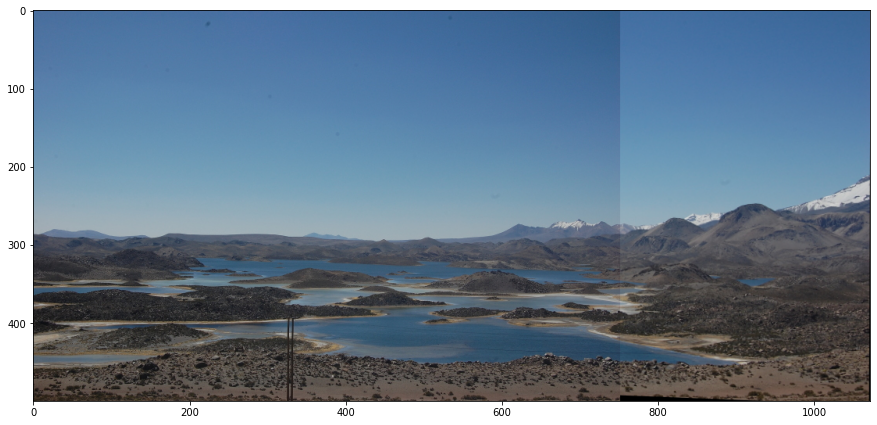

Step 1
Computation 1:  313 (313, 64)
Computation 2:  421 (421, 64)
size (500, 1072, 3)
size (500, 752, 3)


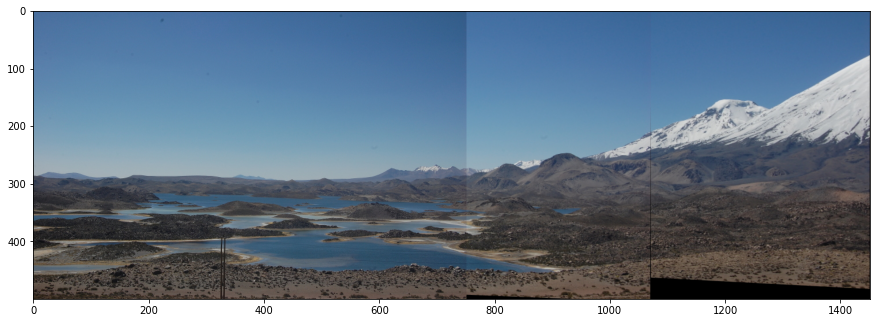

Step 2
Computation 1:  464 (464, 64)
Computation 2:  316 (316, 64)
size (500, 1452, 3)
size (500, 752, 3)


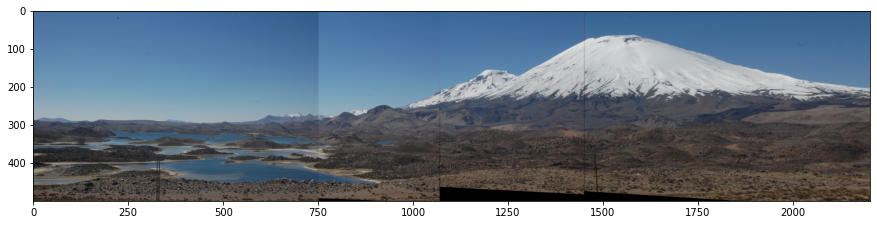

Step 3
Computation 1:  671 (671, 64)
Computation 2:  364 (364, 64)
size (500, 752, 3)
size (500, 2204, 3)


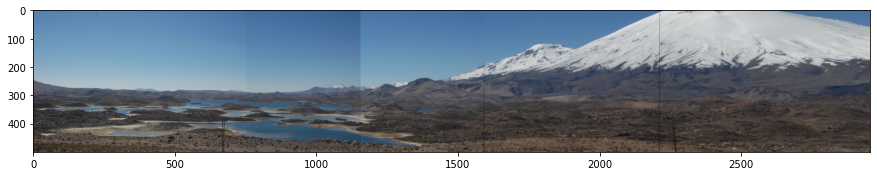

Step 4
Computation 1:  332 (332, 64)
Computation 2:  1097 (1097, 64)
size (500, 752, 3)
size (500, 2956, 3)


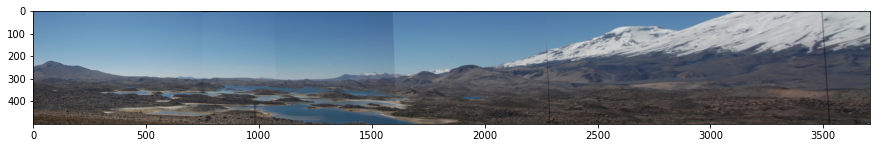

Step 5
Computation 1:  232 (232, 64)
Computation 2:  1252 (1252, 64)
size (500, 752, 3)
size (500, 3708, 3)


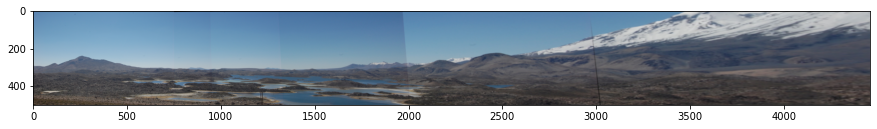

Step 6
Computation 1:  169 (169, 64)
Computation 2:  1193 (1193, 64)


In [67]:
pos1, pos2 = 3, 4
(kp1, desc1) = computeKeyPointsAndDescriptors(images[pos1])
(kp2, desc2) = computeKeyPointsAndDescriptors(images[pos2])
h = findHomography(images[pos1], images[pos2], (kp1, desc1), (kp2, desc2))
output_image = stitching(images[pos1], images[pos2], h, '01')
print("Step 1")
print("Computation 1: ", len(kp1), desc1.shape)
print("Computation 2: ", len(kp2), desc2.shape)

pos1 = 5
(kp1, desc1) = computeKeyPointsAndDescriptors(output_image)
(kp2, desc2) = computeKeyPointsAndDescriptors(images[pos1])
h = findHomography(images[pos1], output_image, (kp1, desc1), (kp2, desc2))
output_image = stitching(output_image, images[pos1], h, '02')
print("Step 2")
print("Computation 1: ", len(kp1), desc1.shape)
print("Computation 2: ", len(kp2), desc2.shape)

pos1 = 6
(kp1, desc1) = computeKeyPointsAndDescriptors(output_image)
(kp2, desc2) = computeKeyPointsAndDescriptors(images[pos1])
h = findHomography(images[pos1],output_image, (kp1, desc1), (kp2, desc2))
output_image = stitching(output_image, images[pos1], h, '03')
print("Step 3")
print("Computation 1: ", len(kp1), desc1.shape)
print("Computation 2: ", len(kp2), desc2.shape)

pos1 = 2
(kp1, desc1) = computeKeyPointsAndDescriptors(images[pos1])
(kp2, desc2) = computeKeyPointsAndDescriptors(output_image)
h = findHomography(images[pos1], output_image, (kp1, desc1), (kp2, desc2))
output_image = stitching(images[pos1], output_image, h, '04')
print("Step 4")
print("Computation 1: ", len(kp1), desc1.shape)
print("Computation 2: ", len(kp2), desc2.shape)

pos1 = 1
(kp1, desc1) = computeKeyPointsAndDescriptors(images[pos1])
(kp2, desc2) = computeKeyPointsAndDescriptors(output_image)
h = findHomography(images[pos1], output_image, (kp1, desc1), (kp2, desc2))
output_image = stitching(images[pos1], output_image, h, '05')
print("Step 5")
print("Computation 1: ", len(kp1), desc1.shape)
print("Computation 2: ", len(kp2), desc2.shape)

pos1 = 0
(kp1, desc1) = computeKeyPointsAndDescriptors(images[pos1])
(kp2, desc2) = computeKeyPointsAndDescriptors(output_image)
h = findHomography(images[pos1], output_image, (kp1, desc1), (kp2, desc2))
output_image = stitching(images[pos1], output_image, h, '06')
print("Step 6")
print("Computation 1: ", len(kp1), desc1.shape)
print("Computation 2: ", len(kp2), desc2.shape)
